# Color quantization on whole data set and yellow line detection

This notebook is highly based on the code Matthew and Junjie have wrotten with minor modifications done by me. Here I used the OpenCV libaray and put a fixed yellow BGR for predicting label.

In [1]:
# import libraries
import numpy as np
from sklearn.cluster import KMeans
from matplotlib import pyplot as plt
import os
import cv2
from pathlib import Path

In [2]:
# define reshaped size
WIDTH = 512
HEIGHT = 512

In [3]:
# define a list with all file names
pl = Path("Parking Lot")
rd = Path("Road")

filenames = [str(file) for file in pl.iterdir()]
filenames = filenames + [str(file) for file in rd.iterdir()]

num_files = len(filenames)

In [4]:
# load in all the resized images
ims = [cv2.resize(cv2.imread(file),(WIDTH,HEIGHT)) for file in filenames]

In [5]:
# reshape the list
pixel_list = [im.reshape((-1, 3)) for im in ims]
pixels = np.concatenate(pixel_list, axis=0)

Now we put a bigger number of cluster to hope it gives better result.

In [6]:
# apply clustering on all images
n_clusters=10

model = KMeans(n_clusters=n_clusters)
model.fit(pixels)

KMeans(n_clusters=10)

In [7]:
# define the yellow color and predict the label 
yellow = np.array([0, 200, 210 ])
yellow_label = model.predict(yellow.reshape((1, -1)))

In [8]:
# save all the clustered images and the resulting images after filtering 

for index in range(num_files):
    filename = filenames[index].split('/')[-1].split('.')[0]
    
    resized_img = pixels[HEIGHT*WIDTH*index:HEIGHT*WIDTH*(index+1)].reshape((HEIGHT, WIDTH, 3))
    output_name = "Output/Color_Quantization/Resized_"+filename+".jpg"
    os.makedirs(os.path.dirname(output_name), exist_ok=True)
    cv2.imwrite(output_name,resized_img)
    
    colors = model.cluster_centers_
    img_labels = model.labels_
    transformed_img = colors[(img_labels[HEIGHT*WIDTH*index:HEIGHT*WIDTH*(index+1)])].reshape((HEIGHT, WIDTH, 3))
    output_name = "Output/Color_Quantization/Transformed_"+filename+".jpg"
    os.makedirs(os.path.dirname(output_name), exist_ok=True)
    cv2.imwrite(output_name,transformed_img)

    mask = (img_labels[HEIGHT*WIDTH*index:HEIGHT*WIDTH*(index+1)] == yellow_label).reshape((HEIGHT, WIDTH, 1))
    masked_image = ims[index]*mask
    output_name = "Output/Color_Quantization/Masked_"+filename+".jpg"
    os.makedirs(os.path.dirname(output_name), exist_ok=True)
    cv2.imwrite(output_name,masked_image)

## Now let's take a look at these masked images and do analysis from there 

Our masked image has the shape: (512, 512, 3)


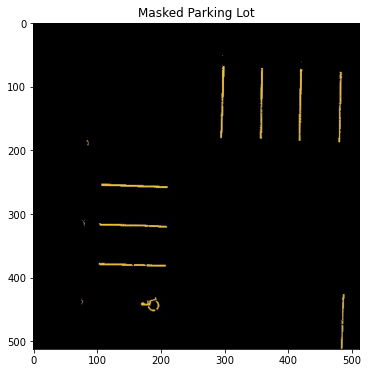

In [9]:
# load in the masked image
filen = "Lot1"
maskedfilename = "Output/Color_Quantization/Masked_"+filen+".jpg"
masked_img = cv2.imread(maskedfilename, 1)
masked_img = cv2.cvtColor(masked_img, cv2.COLOR_BGR2RGB)
plt.figure(figsize=(6,6))
plt.title('Masked Parking Lot');
print("Our masked image has the shape: {}".format(masked_img.shape))
plt.imshow(masked_img)
plt.show()

In [10]:
# Gaussain blurring
gblur = cv2.GaussianBlur(masked_img, (5,5),0)

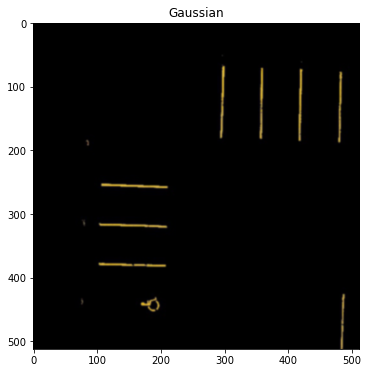

In [11]:
plt.figure(figsize=(6,6))
plt.imshow(gblur)
plt.title('Gaussian');
plt.show()

In [12]:
# two parameters need to play with for canny edge detection
minval = 150
maxval = 250
canny_bF = cv2.Canny(gblur, minval, maxval)

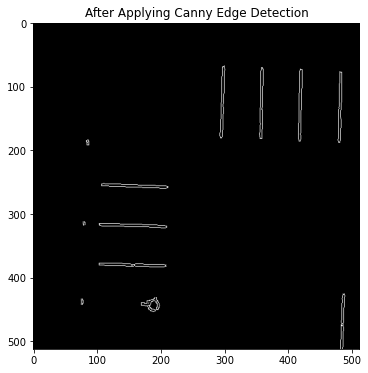

True

In [13]:
plt.figure(figsize=(6,6))
plt.imshow(canny_bF, cmap = 'gray')
plt.title('After Applying Canny Edge Detection');
plt.show()
finaloutname = "Output/Color_Quantization/Edge_"+filen+".jpg"
os.makedirs(os.path.dirname(finaloutname), exist_ok=True)
cv2.imwrite(finaloutname,canny_bF )

In [14]:
# three parameters need to play with in hough transform line detection
resizedfilename = "Output/Color_Quantization/Resized_"+filen+".jpg"
lines = cv2.HoughLinesP(canny_bF, 1, np.pi/180, threshold = 10, minLineLength = 10, maxLineGap = 10)
img_resized = cv2.imread(resizedfilename, 1)

In [15]:
# draw the detected lines
for line in lines:
    x1, y1, x2, y2 = line[0]   
    cv2.line(img_resized, (x1,y1), (x2, y2), ( 0, 0, 255), 2)

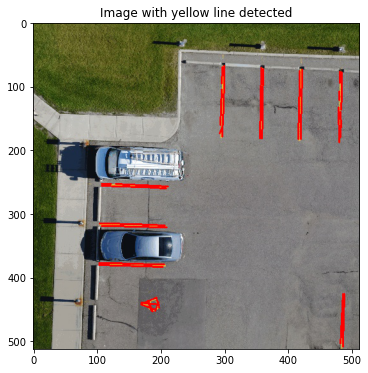

In [16]:
# save the image with line detected and display it
finaloutname = "Output/Color_Quantization/Detected_"+filen+".jpg"
os.makedirs(os.path.dirname(finaloutname), exist_ok=True)
cv2.imwrite(finaloutname, img_resized)

img_resized = cv2.cvtColor(img_resized, cv2.COLOR_BGR2RGB)
plt.figure(figsize=(6,6))
plt.imshow(img_resized)
plt.title('Image with yellow line detected');
plt.show()